## Libraries

In [2]:
!pip install matplotlib pandas seaborn findspark

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 11.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 36.7 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.4/18.4 MB 37.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 37.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [3]:
with open("times.csv", "w") as f:
    f.write("amount of files")
    f.write(",")
    f.write("code_session")
    f.write(",")
    f.write("time")

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import StructType, StructField, LongType, DoubleType, StringType, TimestampType, IntegerType
import glob
from functools import reduce
from pyspark.sql import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

import findspark
findspark.init()

sns.set(style="whitegrid")

amount_of_files = 3

In [5]:
def save_to_time_file(code_session, time):
    with open("times.csv", "a") as f:
        f.write("\n")
        f.write(str(amount_of_files))
        f.write(",")
        f.write(code_session)
        f.write(",")
        f.write(str(time))

## Create the SparkSession 

In [6]:
def setup_spark():
    spark = SparkSession.builder \
        .appName("TaxiOutlierDetection") \
        .master("local[*]") \
        .config("spark.driver.memory", "6g") \
        .config("spark.executor.memory", "6g") \
        .config("spark.sql.shuffle.partitions", "200") \
        .config("spark.sql.adaptive.enabled", "true") \
        .config("spark.driver.maxResultSize", "2g") \
        .getOrCreate()
    
    spark.sparkContext.setLogLevel("WARN")
    print(f"✓ Spark iniciado (versão {spark.version})")
    return spark

spark = setup_spark()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/08 18:01:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


✓ Spark iniciado (versão 3.5.4)


##  Data Loading

This approach handles extreme schema inconsistency by reading each file individually and then merging them in a robust way within Spark's DataFrame API.

### 1 - Get a list of all individual Parquet data files using a wildcard.

In [7]:

data_path_pattern = "../data/yellow_tripdata_*.parquet"
file_list = glob.glob(data_path_pattern)

file_list = file_list[0:amount_of_files]

A list to hold each individual DataFrame after its read and standardized.

In [8]:
dfs = []

print(f"Found {len(file_list)} Parquet files to process.")

Found 3 Parquet files to process.


### 2 - Loop through each file, read it, and standardize it. Then, merge all the individual DataFrames into one.

We use unionByName, which is more powerful than the reader's mergeSchema. It correctly handles schema evolution (e.g., promoting INT to LONG) and missing columns.

In [9]:
init_time_loading_df = time.time()

for file in file_list:
    try:
        df_single = spark.read.parquet(file)

        df_standardized = df_single.toDF(*[c.lower() for c in df_single.columns])
        
        dfs.append(df_standardized)
        print(f"Successfully read and standardized {file}")
    except Exception as e:
        print(f"Could not read file {file}. Error: {e}")

if dfs:
    
    df_raw_strings = reduce(lambda df1, df2: df1.unionByName(df2, allowMissingColumns=True), dfs)

    print(f"✓ Dataset carregado: {df_raw_strings.count():,} registros")
    
    print("\nAll DataFrames successfully merged into one.")
    df_raw_strings.printSchema()

    print("\nSample of the unified data:")
    df_raw_strings.show(5)
else:
    print("No data files were found or read. Please check the path and file permissions.")

end_time_loading_df = time.time()

print(f"time to load files to df: {end_time_loading_df - init_time_loading_df}")
save_to_time_file("loading df", end_time_loading_df - init_time_loading_df)

Successfully read and standardized ../data/yellow_tripdata_2024-01.parquet
Successfully read and standardized ../data/yellow_tripdata_2024-02.parquet
Successfully read and standardized ../data/yellow_tripdata_2024-03.parquet
✓ Dataset carregado: 9,554,778 registros

All DataFrames successfully merged into one.
root
 |-- vendorid: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- ratecodeid: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- pulocationid: integer (nullable = true)
 |-- dolocationid: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- i

## Data Cleaning and Preprocessing

### 1 - Cast all columns from string to their correct final types
 This is the main transformation step. We explicitly cast each column  from the raw string DataFrame to its proper data type.

In [10]:
df = df_raw_strings

### 2 - feature Engineering and filtering
Now we can proceed with the cleaned, correctly-typed DataFrame.

In [11]:
def preprocess_data(df):
    print(f"amount of items before cleaning: {df.count():,} records")
    df_clean = df.filter(
        (col("total_amount") > 0) &
        (col("trip_distance") > 0) &
        (col("passenger_count") > 0) &
        (col("passenger_count") <= 6)
    )
    
    df_clean = df_clean.withColumn(
        "trip_duration",
        (expr("unix_timestamp(tpep_dropoff_datetime)") - expr("unix_timestamp(tpep_pickup_datetime)")) / 60
    )
    
    df_clean = df_clean.filter(
        (col("trip_duration") > 0) &
        (col("trip_duration") < 180)
    )
    
    df_clean = df_clean.withColumn(
        "speed_mph",
        col("trip_distance") / (col("trip_duration") / 60)
    )
    
    print(f"amount of items after cleaning: {df_clean.count():,} records")
    
    return df_clean


init_time_to_clean_df = time.time()
df = preprocess_data(df)
end_time_to_clean_df = time.time()

print(f"time to clean df records (first filter): {end_time_to_clean_df - init_time_to_clean_df}")

save_to_time_file("clean df", end_time_to_clean_df - init_time_to_clean_df)

amount of items before cleaning: 9,554,778 records


[Stage 11:=================================================>      (32 + 4) / 36]

amount of items after cleaning: 8,474,084 records
time to clean df records (first filter): 2.59513521194458


## Exploratory and Aggregate Analysis


The Importance of Total Aggregate Metrics
While descriptive statistics (like mean, standard deviation, min, and max) give us a profile of a "typical trip," the total aggregate metrics reveal the scale and magnitude of the entire operation. They answer high-level questions about the "big picture" of the business, making them essential for business intelligence and strategic reporting.

Analyzing these three metrics is a fundamental step in any similar data project.

`total_trip_count`

**What it Represents:** This metric quantifies the total volume of records (in this case, trips) that were processed and deemed valid after the data cleaning phase.

Strategic Importance:

- Measures Business Volume: It is the most basic and fundamental indicator of activity. It answers the question: "How many transactions did we process?"

- Foundation for KPIs: It serves as the denominator for calculating many Key Performance Indicators (KPIs), such as average revenue per trip (total revenue / total trip count).

- Dataset Validation: It confirms the size of the data sample being analyzed, which lends statistical confidence to other findings.

`total_revenue`

**What it Represents:**  It is the sum of a primary financial column (like total_amount) across all records. It represents the total economic value generated by the service during the analyzed period.

Strategic Importance:

- Financial Performance: It is the top-line measure of the business's financial health. It's the first number executives and investors often look at to assess performance.

- Market Analysis: It helps in understanding the size of the market and the company's role within it.

- Planning and Forecasting: It is essential data for financial models, growth projections, and budgeting.

`total_distance_miles`

**What it Represents:** It is the sum of a key operational metric (in this case, distance). It quantifies the total physical "work" performed by the fleet or service.

Strategic Importance:

- Operational Cost Analysis: Total distance is directly proportional to large-scale variable costs, such as fuel consumption, tire wear, and vehicle maintenance.

- Efficiency Measurement: It is essential for calculating efficiency KPIs like "revenue per mile" or "cost per kilometer," enabling operational optimization.

- Impact and Scale: It provides a tangible measure of the service's operational footprint, which can be used for logistical analysis, environmental impact studies, and communicating the company's scale to stakeholders.

In [12]:
# Basic descriptive statistics
print("Descriptive Statistics for numerical columns:")
df.describe("trip_distance", "fare_amount", "tip_amount", "trip_duration").show()

print("\nTotal Metrics:")
total_metrics = df.agg(
    count("*").alias("total_trip_count"),
    sum("total_amount").alias("total_revenue"),
    sum("trip_distance").alias("total_distance_miles")
)

total_metrics.show()

25/07/08 18:01:28 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Descriptive Statistics for numerical columns:


+-------+-----------------+-----------------+-----------------+--------------------+
|summary|    trip_distance|      fare_amount|       tip_amount|       trip_duration|
+-------+-----------------+-----------------+-----------------+--------------------+
|  count|          8474084|          8474084|          8474084|             8474084|
|   mean|3.439719127164614|18.66949455304061|3.524664644579726|  15.461729558813275|
| stddev|84.73223988320477|17.28471347763824|3.910071323038615|   12.56520426708113|
|    min|             0.01|              0.0|              0.0|0.016666666666666666|
|    max|          98229.4|            999.0|           999.99|  179.71666666666667|
+-------+-----------------+-----------------+-----------------+--------------------+


Total Metrics:


[Stage 17:=================================================>      (32 + 4) / 36]

+----------------+--------------------+--------------------+
|total_trip_count|       total_revenue|total_distance_miles|
+----------------+--------------------+--------------------+
|         8474084|2.3496318435027766E8| 2.914846881999962E7|
+----------------+--------------------+--------------------+



In [13]:
print("\nNumber of Trips by Month:")

init_filter_trip_by_month = time.time()

monthly_pattern = df.groupBy(
        year("tpep_pickup_datetime").alias("year"),
        month("tpep_pickup_datetime").alias("month")
    ) \
    .count() \
    .orderBy("year", "month")

monthly_pattern.count()
end_filter_trip_by_month = time.time()

monthly_pattern.show()

print(f"time to filter trips by month: {end_filter_trip_by_month - init_filter_trip_by_month}")
save_to_time_file("filter by month", end_filter_trip_by_month - init_filter_trip_by_month)


Number of Trips by Month:


[Stage 26:==========================================>             (27 + 9) / 36]

+----+-----+-------+
|year|month|  count|
+----+-----+-------+
|2002|   12|      2|
|2008|   12|      1|
|2009|    1|      4|
|2023|   12|     10|
|2024|    1|2721970|
|2024|    2|2717910|
|2024|    3|3034185|
|2024|    4|      2|
+----+-----+-------+

time to filter trips by month: 2.370734691619873


## 5 - Temporal Analysis

Daily Pattern: Trips by Hour (Weekdays vs. Weekends)

In [14]:
print("Number of Trips by Hour (Weekdays vs. Weekends):")

init_filter_trips_by_hour = time.time()

df = df.withColumn(
    "trip_duration_minutes",
    (unix_timestamp(col("tpep_dropoff_datetime")) - unix_timestamp(col("tpep_pickup_datetime"))) / 60
).withColumn(
    "pickup_hour",
    hour(col("tpep_pickup_datetime"))
).withColumn(
    "pickup_day_of_week",
    dayofweek(col("tpep_pickup_datetime"))
)


df_temporal = df.withColumn(
    "day_type",
    when(col("pickup_day_of_week").isin([1, 7]), "Weekend")
    .otherwise("Weekday")
)

df_temporal.count()
end_filter_trips_by_hour = time.time()

print(f"time filter trips by hour: {end_filter_trips_by_hour - init_filter_trips_by_hour}")
save_to_time_file("filter by hour", end_filter_trips_by_hour - init_filter_trips_by_hour)

df_temporal.show(30)

Number of Trips by Hour (Weekdays vs. Weekends):


time filter trips by hour: 0.9638516902923584
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+------------------+---------------------+-----------+------------------+--------+
|vendorid|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|ratecodeid|store_and_fwd_flag|pulocationid|dolocationid|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|     trip_duration|         speed_mph|trip_duration_minutes|pickup_hour|pickup_day_of_week|day_type|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+----------

Group by day type and hour, then count the trips

In [15]:
init_filter_daily_pattern = time.time()

daily_pattern = df_temporal.groupBy("day_type", "pickup_hour") \
    .count() \
    .orderBy("day_type", "pickup_hour")

daily_pattern.count()
end_filter_daily_pattern = time.time()

print(f"time to filter daily pattern: {end_filter_daily_pattern- init_filter_daily_pattern}")
save_to_time_file("filter daily pattern", end_filter_daily_pattern - init_filter_daily_pattern)

daily_pattern.show(10) 

time to filter daily pattern: 2.347296953201294


[Stage 40:==========================================>             (27 + 9) / 36]

+--------+-----------+------+
|day_type|pickup_hour| count|
+--------+-----------+------+
| Weekday|          0|102701|
| Weekday|          1| 51670|
| Weekday|          2| 30649|
| Weekday|          3| 20320|
| Weekday|          4| 18230|
| Weekday|          5| 35967|
| Weekday|          6| 92365|
| Weekday|          7|200174|
| Weekday|          8|276778|
| Weekday|          9|295938|
+--------+-----------+------+
only showing top 10 rows



In [16]:
print("Analysis of Trips by Specific Day of the Week:")

# Create a column with the full day name from the pickup timestamp.
# The "EEEE" pattern formats the date into the full day name (e.g., "Monday").

init_filter_trips_by_day_of_week = time.time()

df_with_day_name = df.withColumn(
    "pickup_day_name",
    date_format(col("tpep_pickup_datetime"), "EEEE")
)

# Group by day of the week and count the trips.
# We order by the numeric 'pickup_day_of_week' column for correct chronological sorting.
day_of_week_analysis = df_with_day_name.groupBy("pickup_day_of_week", "pickup_day_name") \
    .count() \
    .orderBy("pickup_day_of_week")

day_of_week_analysis.count()
end_filter_trips_by_day_of_week = time.time()

print(f"time to filter trips by day of week: {end_filter_trips_by_day_of_week- init_filter_trips_by_day_of_week}")
save_to_time_file("filter by day of week", end_filter_trips_by_day_of_week - init_filter_trips_by_day_of_week)

day_of_week_analysis.show()

# A more granular analysis by day and hour.
print("\nAnalysis of Trips by Day of Week and Hour:")
day_hour_analysis = df_with_day_name.groupBy("pickup_day_of_week", "pickup_day_name", "pickup_hour") \
    .count() \
    .orderBy("pickup_day_of_week", "pickup_hour")
    
# Show a sample of the detailed results.
day_hour_analysis.show(30)

Analysis of Trips by Specific Day of the Week:


time to filter trips by day of week: 2.7403388023376465


+------------------+---------------+-------+
|pickup_day_of_week|pickup_day_name|  count|
+------------------+---------------+-------+
|                 1|         Sunday|1053476|
|                 2|         Monday|1032992|
|                 3|        Tuesday|1171124|
|                 4|      Wednesday|1281163|
|                 5|       Thursday|1367053|
|                 6|         Friday|1281759|
|                 7|       Saturday|1286517|
+------------------+---------------+-------+


Analysis of Trips by Day of Week and Hour:


[Stage 52:===================================================>    (33 + 3) / 36]

+------------------+---------------+-----------+-----+
|pickup_day_of_week|pickup_day_name|pickup_hour|count|
+------------------+---------------+-----------+-----+
|                 1|         Sunday|          0|61423|
|                 1|         Sunday|          1|49439|
|                 1|         Sunday|          2|34093|
|                 1|         Sunday|          3|24891|
|                 1|         Sunday|          4|12267|
|                 1|         Sunday|          5| 5420|
|                 1|         Sunday|          6| 8119|
|                 1|         Sunday|          7|12999|
|                 1|         Sunday|          8|21149|
|                 1|         Sunday|          9|34083|
|                 1|         Sunday|         10|47464|
|                 1|         Sunday|         11|56391|
|                 1|         Sunday|         12|63483|
|                 1|         Sunday|         13|67194|
|                 1|         Sunday|         14|68952|
|         

### Plot 1: Total Trips by Day of the Week

/tmp/ipykernel_37/3005328610.py:8: FutureWarning:                               

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


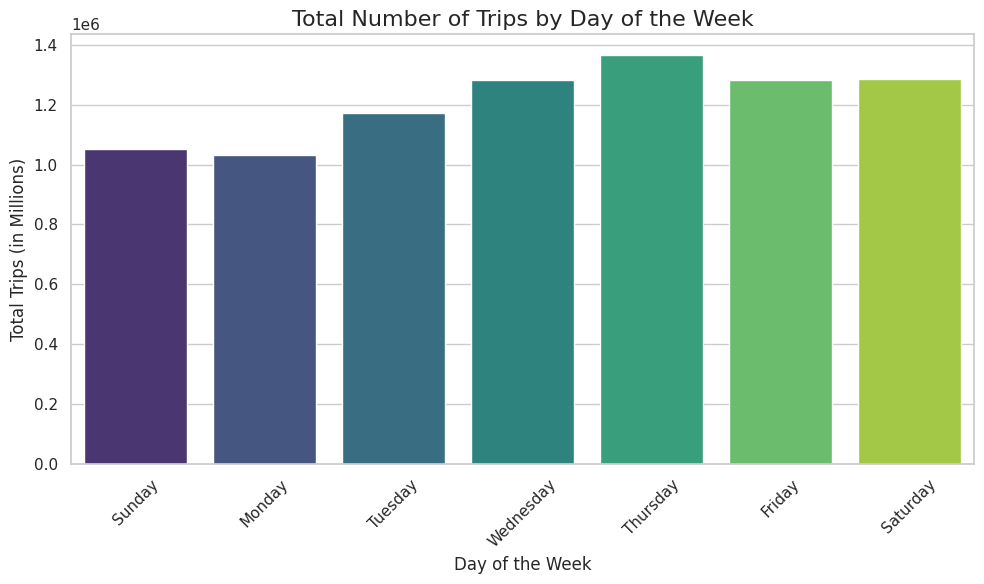

In [17]:
# Convert the aggregated Spark DataFrame to a Pandas DataFrame (its a war crime? maybe)
# but this operation is safe because the aggregated DataFrame has only 7 rows.
pandas_day_of_week = day_of_week_analysis.toPandas()

# Create the plot using Seaborn and Matplotlib
plt.figure(figsize=(10, 6)) # Set the figure size for better readability

sns.barplot(
    data=pandas_day_of_week,
    x='pickup_day_name',
    y='count',
    palette='viridis' # Use a pleasant color palette
)

plt.title('Total Number of Trips by Day of the Week', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Total Trips (in Millions)', fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Plot 2: Hourly Trip Pattern (Weekday vs. Weekend) 

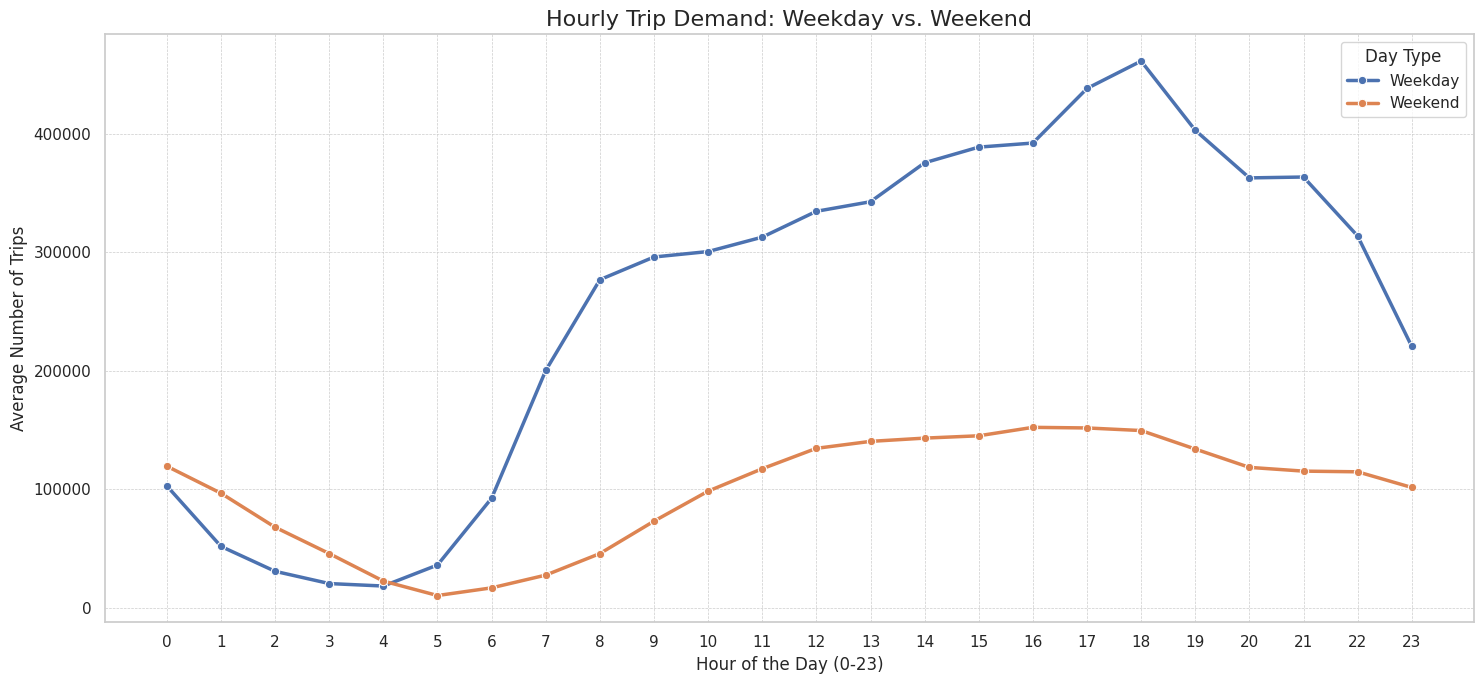

In [18]:
# Same war crime
pandas_daily_pattern = daily_pattern.toPandas()

plt.figure(figsize=(15, 7)) # Set a wider figure size for hourly data

sns.lineplot(
    data=pandas_daily_pattern,
    x='pickup_hour',
    y='count',
    hue='day_type', # This will create separate lines for 'Weekday' and 'Weekend'
    marker='o', # Add markers to each data point
    linewidth=2.5
)

plt.title('Hourly Trip Demand: Weekday vs. Weekend', fontsize=16)
plt.xlabel('Hour of the Day (0-23)', fontsize=12)
plt.ylabel('Average Number of Trips', fontsize=12)
plt.xticks(range(0, 24)) # Ensure all hours are shown on the x-axis
plt.legend(title='Day Type')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

## Detecção de Outliers

Aplicamos uma detecção combinada usando o método do intervalo interquartil (IQR) e o Z-Score para identificar valores anômalos em `total_amount`.  

- **IQR**: identifica pontos muito distantes da “caixa” entre os quartis 1 e 3.  
- **Z-Score**: identifica pontos que estão muitos desvios padrão acima da média.

Essa combinação torna a detecção mais robusta e menos suscetível a falsos positivos.


In [19]:
def detect_outliers(df, column="total_amount", zscore_threshold=3.0, iqr_factor=1.5, sample_fraction=0.02):
    init_detect_outliers = time.time()
    print(f"🔍 Analisando coluna: {column}")

    stats = df.select(
        expr(f"percentile_approx({column}, 0.25)").alias("q1"),
        expr(f"percentile_approx({column}, 0.75)").alias("q3"),
        mean(column).alias("mean"),
        stddev(column).alias("stddev")
    ).collect()[0]

    q1, q3 = stats['q1'], stats['q3']
    iqr = q3 - q1
    mean_val = stats['mean']
    stddev_val = stats['stddev']

    lower_iqr = q1 - iqr_factor * iqr
    upper_iqr = q3 + iqr_factor * iqr
    upper_zscore = mean_val + zscore_threshold * stddev_val

    print(f"📊 Estatísticas:")
    print(f"  Q1: {q1:.2f} | Q3: {q3:.2f} | IQR: {iqr:.2f}")
    print(f"  Média: {mean_val:.2f} | StdDev: {stddev_val:.2f}")
    print(f"  Limites: IQR[{lower_iqr:.2f}, {upper_iqr:.2f}], Z-Score superior: {upper_zscore:.2f}")

    df_outliers = df.withColumn(
        "is_outlier",
        when(
            (col(column) < lit(lower_iqr)) |
            (col(column) > lit(upper_iqr)) |
            (col(column) > lit(upper_zscore)),
            1.0
        ).otherwise(0.0)
    )

    total = df_outliers.count()
    outliers = df_outliers.filter(col("is_outlier") == 1.0).count()
    
    end_detect_outliers = time.time()

    print(f"time to detect_outliers: {end_detect_outliers - init_detect_outliers}")
    save_to_time_file("detecting outliers", end_detect_outliers - init_detect_outliers)
    
    print(f"✅ Outliers detectados: {outliers:,} de {total:,} ({(outliers/total)*100:.2f}%)")

    print(f"📷 Gerando visualização com {sample_fraction*100:.1f}% dos dados...")
    pdf = df_outliers.sample(sample_fraction).toPandas()

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.boxplot(x="is_outlier", y=column, data=pdf, ax=axes[0])
    axes[0].set_title(f'Distribuição de {column} por status de Outlier')
    axes[0].set_xlabel("É Outlier?")
    axes[0].set_ylabel(column)

    if "trip_distance" in pdf.columns:
        sns.scatterplot(
            x="trip_distance", y=column,
            hue="is_outlier",
            data=pdf, alpha=0.6, ax=axes[1]
        )
        axes[1].set_title(f'{column} vs Trip Distance (Colorido por Outlier)')
    else:
        axes[1].text(0.5, 0.5, "Coluna 'trip_distance' não disponível",
                     horizontalalignment='center', verticalalignment='center')

    plt.tight_layout()
    plt.show()

    return df_outliers

🔍 Analisando coluna: total_amount


📊 Estatísticas:
  Q1: 15.60 | Q3: 29.04 | IQR: 13.44
  Média: 27.73 | StdDev: 21.93
  Limites: IQR[-4.56, 49.20], Z-Score superior: 93.53


time to detect_outliers: 6.653059720993042
✅ Outliers detectados: 952,505 de 8,474,084 (11.24%)
📷 Gerando visualização com 2.0% dos dados...


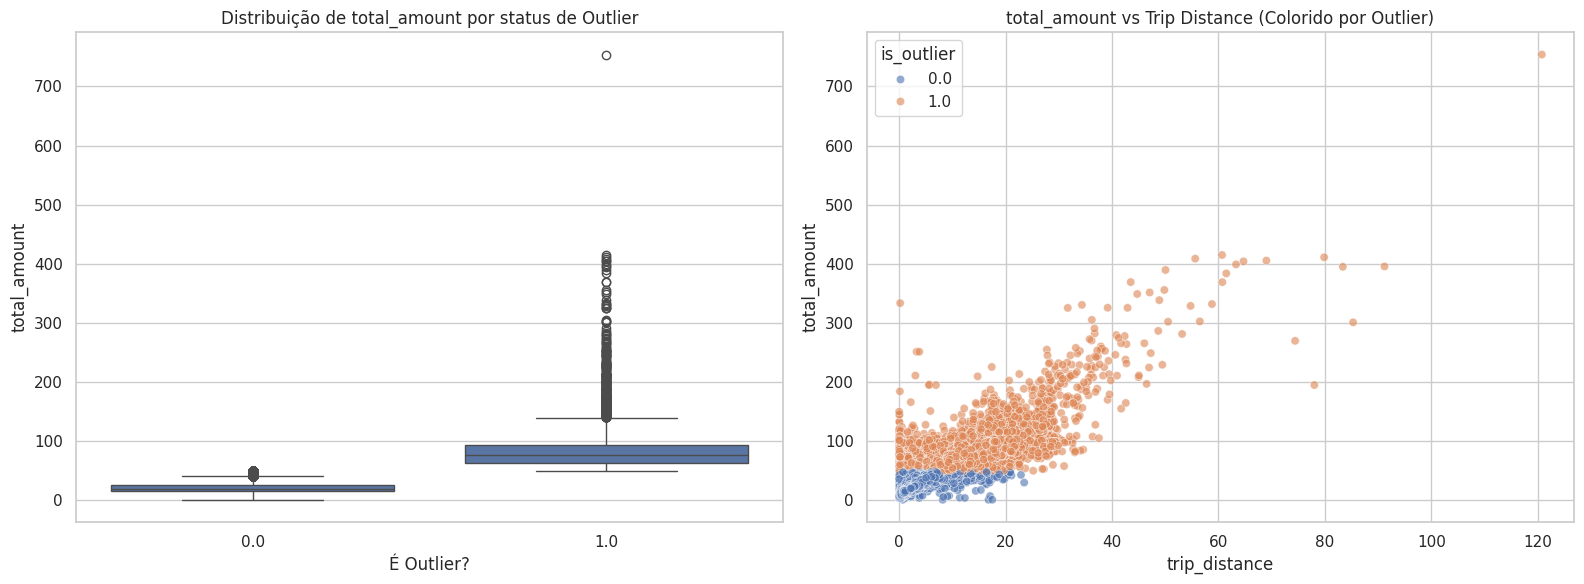

In [20]:
df_outliers = detect_outliers(df)
